## Drug Effect

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import expectation_reflection as ER

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
df = pd.read_csv('../drug_data.csv')
df.head()

,SampleID,Fly,Survival,Concentration,Line,Sex,Replicate,Drug,Number
0,1,0.229.Female.1.Trifluroperazine.1,96,0,229,Female,1,Trifluroperazine,1
1,2,0.229.Female.1.Trifluroperazine.10,96,0,229,Female,1,Trifluroperazine,10
2,3,0.229.Female.1.Trifluroperazine.11,96,0,229,Female,1,Trifluroperazine,11
3,4,0.229.Female.1.Trifluroperazine.12,96,0,229,Female,1,Trifluroperazine,12
4,5,0.229.Female.1.Trifluroperazine.13,96,0,229,Female,1,Trifluroperazine,13


In [4]:
df = df.drop(['SampleID','Fly'],axis=1)
df1 = df.pop('Survival') # remove column diagnosis and store it in df1
df['Survival'] = df1 # add df1 to df as a 'new' column
df.head()

,Concentration,Line,Sex,Replicate,Drug,Number,Survival
0,0,229,Female,1,Trifluroperazine,1,96
1,0,229,Female,1,Trifluroperazine,10,96
2,0,229,Female,1,Trifluroperazine,11,96
3,0,229,Female,1,Trifluroperazine,12,96
4,0,229,Female,1,Trifluroperazine,13,96


In [5]:
# select features and target:
df = np.array(df)

# features:
X = df[:,:-1]
l,n = X.shape
#print(l,n)

# target:
y = df[:,-1].astype(float)
# convert 1,0 to 1,-1:
#y = 2*y - 1

### Clean data

In [6]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')

# Concentration
x0 = X[:,0]
#print(np.unique(x0))
x0[np.where(x0=='12_5')] = 12.5
#print(np.unique(x0))
x0 = x0.astype(float)
#print(np.unique(x0))

# line = X[:,1] = {229,703,900} --> 3
x1 = onehot_encoder.fit_transform(X[:,1].reshape(-1,1))

# sex = X[:,2] = {Female,Male} --> 2
x2 = onehot_encoder.fit_transform(X[:,2].reshape(-1,1))

# Replicate
x3 = X[:,3]
#print(np.unique(x3))
x3 = x3.astype(float)
#print(np.unique(x3))

# Drug = X[:,4] = {Trifluroperazine,Cdcl2} --> 2
x4 = onehot_encoder.fit_transform(X[:,4].reshape(-1,1))

# Number
x5 = X[:,5]
#print(np.unique(x5))
x5 = x5.astype(float)
#print(np.unique(x5))

In [7]:
# Combine every variables
Xnew = np.hstack([x0[:,np.newaxis],x1])
Xnew = np.hstack([Xnew,x2])
Xnew = np.hstack([Xnew,x3[:,np.newaxis]])
Xnew = np.hstack([Xnew,x4])
#Xnew = np.hstack([Xnew,x5[:,np.newaxis]])

Xnew.shape

(3240, 9)

In [8]:
# convert Servival to -1 if < 72, 1 if =>72:
ynew = np.ones(l)
ynew[y < 72.] = -1.
ynew.shape

(3240,)

In [9]:
X = Xnew
y = ynew

### Shuffle data

In [10]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [11]:
#from sklearn.preprocessing import StandardScaler
#X = StandardScaler().fit_transform(X)

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

### Prediction

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def ML_inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=20,regu=0.001)
        y_pred = ER.predict(X_test,h0,w)
        accuracy = accuracy_score(y_test,y_pred)
        
    else:
        if method == 'logistic_regression':
            model = LogisticRegression(solver='liblinear')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)        
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)        
        accuracy = accuracy_score(y_test,y_pred)
    return accuracy

In [13]:
list_methods=['expectation_reflection','naive_bayes','logistic_regression','decision_tree','random_forest']

In [14]:
def compare_ML_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)

        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y_train0)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = ML_inference(X_train,y_train,X_test,y_test,method)
            #print('% 20s :'%method,accuracy)            
        #print(y_train.shape[0],y_test.shape[0])

    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [15]:
list_train_size = [1.,0.8,0.6,0.4,0.2,0.1,0.05,0.02,0.01]

acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_ML_inference(X,y,train_size)
    print(train_size,acc[i,:])

(1.0, array([0.93828704, 0.83597222, 0.93828704, 0.93959877, 0.93828704]))
(0.8, array([0.93868827, 0.83674383, 0.93887346, 0.94035494, 0.93882716]))
(0.6, array([0.93878086, 0.83762346, 0.93882716, 0.93916667, 0.93910494]))
(0.4, array([0.93694444, 0.83938272, 0.93708333, 0.9374537 , 0.93777778]))
(0.2, array([0.93513889, 0.84646605, 0.93294753, 0.93072531, 0.93901235]))
(0.1, array([0.93228395, 0.85205247, 0.92165123, 0.91322531, 0.93697531]))
(0.05, array([0.92705247, 0.83350309, 0.9045679 , 0.90510802, 0.9379784 ]))
(0.02, array([0.90566358, 0.78975309, 0.85908951, 0.88833333, 0.86026235]))
(0.01, array([0.87314815, 0.76384259, 0.77279321, 0.86853395, 0.6608179 ]))


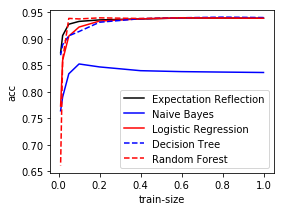

In [21]:
plt.figure(figsize=(4,3))
plt.plot(list_train_size,acc[:,0],'k-',label='Expectation Reflection')
plt.plot(list_train_size,acc[:,1],'b-',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r-',label='Logistic Regression')
plt.plot(list_train_size,acc[:,3],'b--',label='Decision Tree')
plt.plot(list_train_size,acc[:,4],'r--',label='Random Forest')
plt.xlabel('train-size')
plt.ylabel('acc')
#plt.ylim([0.9,0.95])
plt.legend()